In [1]:
from Bio import SeqIO, SeqUtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict

### Fastq file processing functions. 
Considering the minimum good positions in read percentage and the minimum quality
* The first function processes reads and counts all the fetures
* The second one is a helper function for gc content counting

In [2]:
def process_fastq_file(filename, minimum_quality=0.6, minimum_positions_percentage=0.4):
    mean_phred_quality = defaultdict(int)
    gc_content = defaultdict(int)
    reads_count = 0
    for read in SeqIO.parse(filename, 'fastq'): # reading each read using Bio lib 
        reads_count += 1
        seq = read.seq # getting the read sequence
        phred_quality = read.letter_annotations['phred_quality'] # getting the per letter quality
        normalized_phred_quality = [10 ** ((-e + 31) / 10) for e in phred_quality] # getting base-calling error using 10 ** (-Q / 10)
        for i, q in enumerate(normalized_phred_quality): # adding quality to get mean quality per read
            mean_phred_quality[i] += q 
        
        good_positions_percentage = sum([1 if q > minimum_quality else 0 for q in normalized_phred_quality]) / len(normalized_phred_quality)
        if good_positions_percentage > minimum_positions_percentage: # considering only reads with good quality
            gc_content[get_read_gc_content(seq, normalized_phred_quality)] += 1
    
    return {k: v / reads_count * 100 for k, v in mean_phred_quality.items()}, gc_content # returning the per-base error probability and gc-content lists
            
def get_read_gc_content(read_seq, quality, minimum_quality=0.6):
    gc_count = 0
    nucl_count = 0
    for letter, qual in zip(read_seq, quality):
        if letter in 'ACTGU' and qual > minimum_quality: # considering the good quality and correct bases only
            nucl_count += 1
            if letter in "GC":
                gc_count += 1
    return round(gc_count / nucl_count * 100, 0) # returning the good bases gc percent
            

### Plotting function
Plots the per-base error probability and gc-content for reads in a given file

In [3]:
def draw_gc_quality(filename):
    reads_quality, gc_content = process_fastq_file(filename)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(f'Plotting {filename} per-base error probability and gc-content')
    
    lists = sorted(reads_quality.items())
#     print(lists)
    x, y = zip(*lists)
    ax1.plot(x, y, '+g', label='Error probability')
    
    lists = sorted(gc_content.items())
#     print(lists)
    x, y = zip(*lists)
    ax2.plot(x, y, '+g', label='GC-content')
    plt.show()

### Checking the implemented functions using paired-end sample reads and fastqc

Checking the frag.R1.fastq

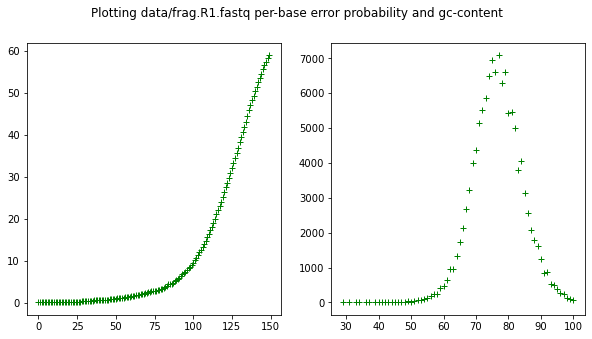

In [4]:
draw_gc_quality('data/frag.R1.fastq')

The fastqc results
<table>
  <tr>
    <td><img src="img/r1_gc.png" width="400" height="400"></td>
    <td><img src="img/r1_per_base_quality.png" width="400" height="400"></td>
  </tr>
</table>

Checking the frag.R2.fastq

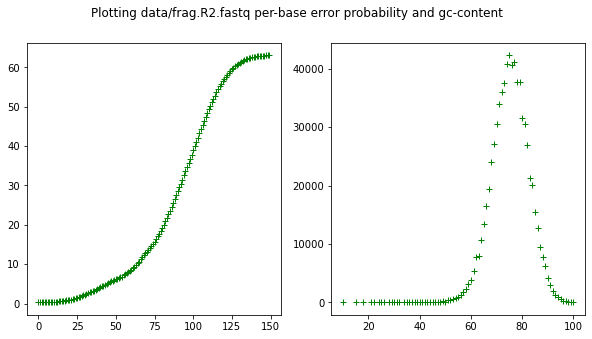

In [5]:
draw_gc_quality('data/frag.R2.fastq')

The fastqc results
<table>
  <tr>
    <td><img src="img/r2_gc.png" width="400" height="400"></td>
    <td><img src="img/r2_per_base_quality.png" width="400" height="400"></td>
  </tr>
</table>

**Summary**: GC-content looks the same as in fastqc. For the error probability plot there is no exact analog in fastqc, but the quality scores plot also shows that for the both files there are problens with reads' quality in the end.